In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import time

In [2]:
MIN = 10
FLANN_INDEX_KDTREE = 0
starttime = time.time()
img1 = cv2.imread('concat1.jpg')  # query
img2 = cv2.imread('concat2.jpg')  # train
imageA = cv2.resize(img1, (0, 0), fx=0.2, fy=0.2)
imageB = cv2.resize(img2, (0, 0), fx=0.2, fy=0.2)
sift = cv2.SIFT_create()
kp1, descrip1 = sift.detectAndCompute(imageA, None)
kp2, descrip2 = sift.detectAndCompute(imageB, None)
# 创建字典
indexParams = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
searchParams = dict(checks=50)
flann = cv2.FlannBasedMatcher(indexParams, searchParams)
match = flann.knnMatch(descrip1, descrip2, k=2)
good = []
# 过滤特征点
for i, (m, n) in enumerate(match):
    if m.distance < 0.75 * n.distance:
        good.append(m)

# 当筛选后的匹配对大于10时，计算视角变换矩阵
if len(good) > MIN:
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    ano_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
    M, mask = cv2.findHomography(src_pts, ano_pts, cv2.RANSAC, 5.0)
    warpImg = cv2.warpPerspective(imageB, np.linalg.inv(M), (imageA.shape[1] + imageB.shape[1], imageB.shape[0]))
    direct = warpImg.copy()
    direct[0:imageA.shape[0], 0:imageB.shape[1]] = imageA
    simple = time.time()

# show('res', warpImg)
rows, cols = imageA.shape[:2]
print(rows)
print(cols)
for col in range(0, cols):
    # 开始重叠的最左端
    if imageA[:, col].any() and warpImg[:, col].any():
        left = col
        print(left)
        break

for col in range(cols - 1, 0, -1):
    # 重叠的最右一列
    if imageA[:, col].any() and warpImg[:, col].any():
        right = col
        print(right)
        break
# 加权处理
res = np.zeros([rows, cols, 3], np.uint8)
for row in range(0, rows):
    for col in range(0, cols):
        if not imageA[row, col].any():  # 如果没有原图，用旋转的填充
            res[row, col] = warpImg[row, col]
        elif not warpImg[row, col].any():
            res[row, col] = imageA[row, col]
        else:
            srcImgLen = float(abs(col - left))
            testImgLen = float(abs(col - right))
            alpha = srcImgLen / (srcImgLen + testImgLen)
            res[row, col] = np.clip(imageA[row, col] * (1 - alpha) + warpImg[row, col] * alpha, 0, 255)

warpImg[0:imageA.shape[0], 0:imageA.shape[1]] = res
final = time.time()
print(final - starttime)
cv2.imwrite('concat_res.jpg', warpImg)

288
384
176
383
1.4873316287994385


True

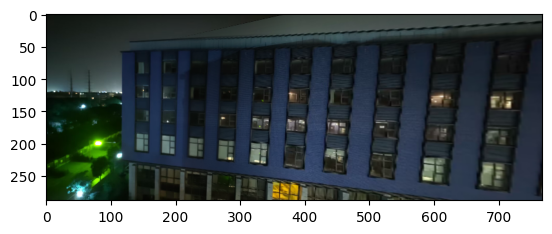

In [3]:
plt.imshow(warpImg)
plt.show()